# <b>Movie Recommendation System<b>

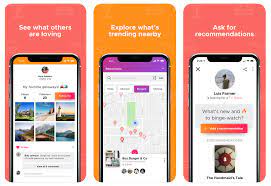

## <b>Table of Contents<b>
1. Businesss Overview
2. Reading in the Data
3. Visualizing the Data and Creating New DF's
   - Creating `df_movies_and_raters`
   - Creating `df_movies_raters_genres`
   - Creating `df_movies_raters_2_genres`
4. Identifying and Investigating "Super Users"
5. Modeling
   - Naive Baseline Model
   - XG Boost Model
6. Conclusions
7. Next Steps


## Business Overview

Likewise aims to implement a movie recommendation system to enhance user experience and engagement on their platform. The primary business problem they face is to deliver highly accurate and relevant movie recommendations to each user based on their individual preferences and behavior

Challenges to address:

Personalization: The recommendation system needs to understand each user's unique tastes, preferences, and viewing history to provide personalized movie suggestions. This requires effective user profiling and data analysis.

Cold Start Problem: New users and movies have limited historical data, making it challenging to provide accurate recommendations. The system must address this "cold start" problem effectively.

Diverse Content: The system should recommend a wide variety of movies, catering to users with different interests and avoiding recommendation bias towards certain genres or types of content.

To overcome these challenges and meet the stakeholders' expectations, Likewise needs to develop a robust and sophisticated movie recommendation algorithm, supported by a reliable data infrastructure, and regularly update and refine the system to adapt to changing user preferences and trends.

In [242]:
import surprise
from surprise.prediction_algorithms import *
from surprise import Reader, Dataset


from surprise.model_selection import cross_validate
from surprise.prediction_algorithms import SVD
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline
from surprise.model_selection import GridSearchCV
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy


import datetime as dt

import xgboost as xgb

import numpy as np
import pandas as pd

import sqlalchemy
from sqlalchemy import create_engine, text
import sqlite3


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval

import matplotlib.pyplot as plt
import seaborn as sns

In [243]:
engine = create_engine("sqlite+pysqlite:///:memory:")

## Reading in the tables

### Dataframes


In [244]:
movies_df = pd.read_csv('movies.csv')

In [245]:
ratings_df = pd.read_csv('ratings.csv')

## Previewing the data

### Exploring `movies.csv`

In [246]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [247]:
#Note: might want to split genres into separate columns
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


### Exploring `ratings.csv`

In [248]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [249]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [250]:
ratings_df.tail()

,userId,movieId,rating,timestamp
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352
100835,610,170875,3.0,1493846415


In [251]:
ratings_df['movieId'].value_counts()

356       329
318       317
296       307
593       279
2571      278
         ... 
5986        1
100304      1
34800       1
83976       1
8196        1
Name: movieId, Length: 9724, dtype: int64

In [252]:
ratings_df['userId'].value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64

### Exploring distribution of ratings (score, count)

In [253]:
stats = ratings_df[['rating', 'timestamp']].describe()
stats

,rating,timestamp
count,100836.000000,1.008360e+05
mean,3.501557,1.205946e+09
std,1.042529,2.162610e+08
min,0.500000,8.281246e+08
25%,3.000000,1.019124e+09
50%,3.500000,1.186087e+09
75%,4.000000,1.435994e+09
max,5.000000,1.537799e+09


In [254]:
print(dt.datetime.fromtimestamp(stats.loc['min', 'timestamp']))
print(dt.datetime.fromtimestamp(stats.loc['max', 'timestamp']))

1996-03-29 13:36:55
2018-09-24 09:27:30


In [255]:
# create a variable for easier reuse
user_ratings_count = ratings_df['userId'].value_counts()

# calculate mean
mean_ratings = user_ratings_count.mean()
print("Mean: ", mean_ratings)

# calculate median
median_ratings = user_ratings_count.median()
print("Median: ", median_ratings)

# calculate mode
mode_ratings = user_ratings_count.mode()[0]
print("Mode: ", mode_ratings)


Mean:  165.30491803278687
Median:  70.5
Mode:  21


## Visualizing movie popularity and user activity

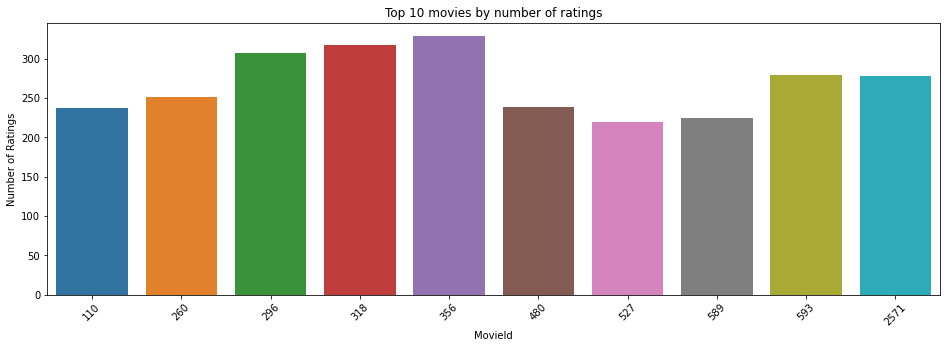

In [256]:
# Top 10 movies with the most ratings

# creating variables
movies_rated_count = ratings_df['movieId'].value_counts()
top_movies = movies_rated_count[:10]

plt.figure(figsize=(16,5))
sns.barplot(x=top_movies.index, y=top_movies.values)
plt.xlabel("MovieId")
plt.ylabel("Number of Ratings")
plt.title("Top 10 movies by number of ratings")
plt.xticks(rotation=45)
plt.show();


## Join movies and ratings + create 3 versions of the dataset
1. `df_movies_and_raters`: each record is a user, genres are left in one column as in the original dataset
2. `df_movies_raters_genres`: each record is a user, genres are split into 9 different columns
3. `df_movies_raters_2_genres`: each record is a user, genres are split into 2 columns, `main_genre` contains the first in the list, `subgenre_1` contains the second.

### SQL

In [257]:
movies_df.to_sql('movies', con=engine, if_exists='replace')

In [258]:
ratings_df.to_sql('ratings',con=engine, if_exists='replace')

### Creating `df_movies_and_raters`

In [259]:
query = \
"""
SELECT  r.userID, r.rating, r.movieID, m.title, m.genres
FROM ratings as r
LEFT JOIN movies AS m ON m.movieId = r.movieId;

"""
df_movies_and_raters = pd.read_sql_query(sql=text(query), con=engine.connect())

In [260]:
df_movies_and_raters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int64  
 1   rating   100836 non-null  float64
 2   movieId  100836 non-null  int64  
 3   title    100836 non-null  object 
 4   genres   100836 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 3.8+ MB


In [261]:
df_movies_and_raters.head()

,userId,rating,movieId,title,genres
0,1,4.0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,4.0,3,Grumpier Old Men (1995),Comedy|Romance
2,1,4.0,6,Heat (1995),Action|Crime|Thriller
3,1,5.0,47,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,5.0,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


### Creating `df_movies_raters_genres`




In [262]:
df_movies_and_raters_copy = df_movies_and_raters.copy()

In [263]:
# Split 'genres' into separate genres
df_movies_and_raters_copy['genres'] = df_movies_and_raters_copy['genres'].str.split('|')

In [264]:
df_movies_and_raters_copy.head()

,userId,rating,movieId,title,genres
0,1,4.0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,1,4.0,3,Grumpier Old Men (1995),"[Comedy, Romance]"
2,1,4.0,6,Heat (1995),"[Action, Crime, Thriller]"
3,1,5.0,47,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]"
4,1,5.0,50,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]"


In [265]:
# Create individual genre columns
split = pd.DataFrame(df_movies_and_raters_copy['genres'].to_list(), columns=['main_genre', 'subgenre_1', 'subgenre_2', 'subgenre_3', 'subgenre_4', 'subgenre_5', 'subgenre_6', 'subgenre_7', 'subgenre_8', 'subgenre_9'])

# Concatenate the new columns with the original dataframe
df_movies_and_raters_copy = pd.concat([df_movies_and_raters_copy, split], axis=1)

df_movies_and_raters_copy.head()


,userId,rating,movieId,title,genres,main_genre,subgenre_1,subgenre_2,subgenre_3,subgenre_4,subgenre_5,subgenre_6,subgenre_7,subgenre_8,subgenre_9
0,1,4.0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]",Adventure,Animation,Children,Comedy,Fantasy,None,None,None,None,None
1,1,4.0,3,Grumpier Old Men (1995),"[Comedy, Romance]",Comedy,Romance,None,None,None,None,None,None,None,None
2,1,4.0,6,Heat (1995),"[Action, Crime, Thriller]",Action,Crime,Thriller,None,None,None,None,None,None,None
3,1,5.0,47,Seven (a.k.a. Se7en) (1995),"[Mystery, Thriller]",Mystery,Thriller,None,None,None,None,None,None,None,None
4,1,5.0,50,"Usual Suspects, The (1995)","[Crime, Mystery, Thriller]",Crime,Mystery,Thriller,None,None,None,None,None,None,None


### Clean up columns for `df_movies_raters_genres`

In [266]:
selected_columns = ['userId', 'movieId', 'title',	'rating', 'main_genre', 'subgenre_1', 'subgenre_2', 'subgenre_3', 'subgenre_4', 'subgenre_5', 'subgenre_6', 'subgenre_7', 'subgenre_8', 'subgenre_9']

df_movies_raters_genres = df_movies_and_raters_copy[selected_columns].copy()

In [267]:
df_movies_raters_genres.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId      100836 non-null  int64  
 1   movieId     100836 non-null  int64  
 2   title       100836 non-null  object 
 3   rating      100836 non-null  float64
 4   main_genre  100836 non-null  object 
 5   subgenre_1  84422 non-null   object 
 6   subgenre_2  55860 non-null   object 
 7   subgenre_3  23971 non-null   object 
 8   subgenre_4  7270 non-null    object 
 9   subgenre_5  1751 non-null    object 
 10  subgenre_6  363 non-null     object 
 11  subgenre_7  3 non-null       object 
 12  subgenre_8  2 non-null       object 
 13  subgenre_9  2 non-null       object 
dtypes: float64(1), int64(2), object(11)
memory usage: 10.8+ MB


### Creating `df_movies_raters_2_genres`

In [268]:
selected_columns = ['userId', 'movieId', 'title',	'rating', 'main_genre', 'subgenre_1']

df_movies_raters_2_genres = df_movies_and_raters_copy[selected_columns].copy()

## Visualize previous bar chart with movie titles from our new dataframe + visualize `main_genre` popularity

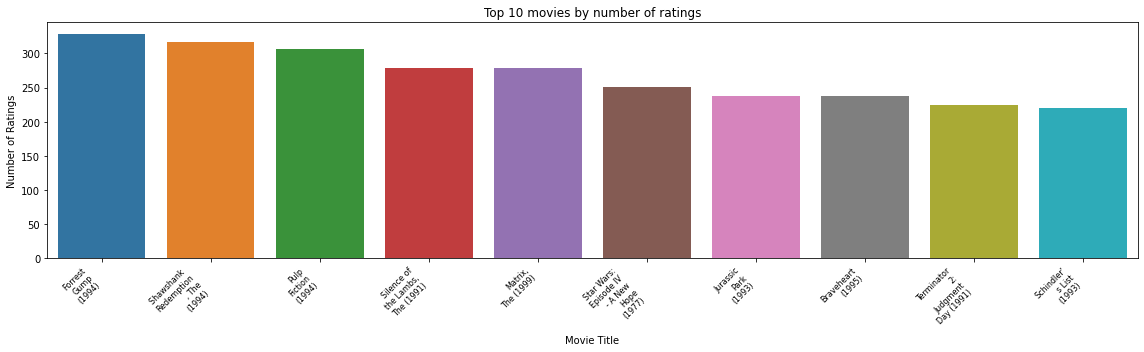

In [269]:
# create variables for easier reuse
movies_rated_count = df_movies_raters_genres['title'].value_counts()


# Top 10 movies with the most ratings
top_movies = movies_rated_count[:10]

plt.figure(figsize=(16,5))
sns.barplot(x=top_movies.index, y=top_movies.values)
plt.xlabel("Movie Title")
plt.ylabel("Number of Ratings")
plt.title("Top 10 movies by number of ratings")

xticks_labels = top_movies.index # or replace this with your list of movie titles
plt.xticks(np.arange(len(xticks_labels)), xticks_labels, rotation=45, ha='right', fontsize=8)
plt.tight_layout()

# using textwrap to split long movie titles into multiple lines.
import textwrap
xticks_labels = [textwrap.fill(label, width=10) for label in xticks_labels]
plt.xticks(np.arange(len(xticks_labels)), xticks_labels, rotation=45, ha='right', fontsize=8)
plt.tight_layout()

plt.show();



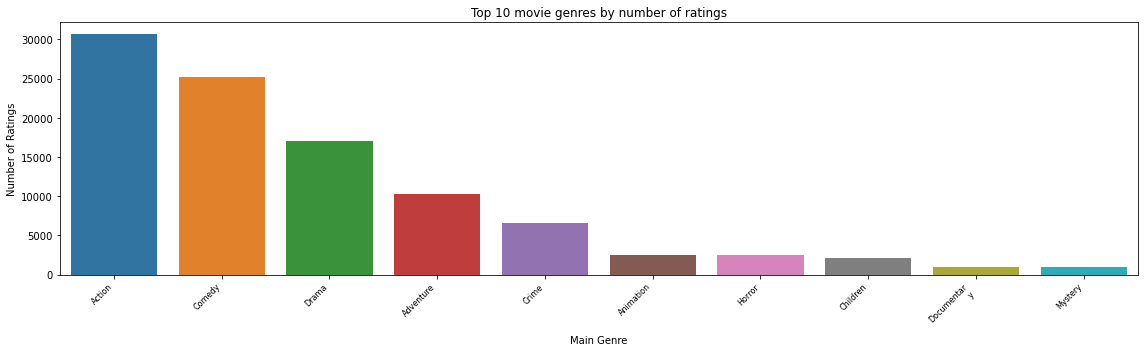

In [270]:
# create variables for easier reuse
genres_rated_count = df_movies_raters_genres['main_genre'].value_counts()


# Top 10 genres with the most ratings
top_genres = genres_rated_count[:10]

plt.figure(figsize=(16,5))
sns.barplot(x=top_genres.index, y=top_genres.values)
plt.xlabel("Main Genre")
plt.ylabel("Number of Ratings")
plt.title("Top 10 movie genres by number of ratings")

xticks_labels = top_genres.index # or replace this with your list of movie titles
plt.xticks(np.arange(len(xticks_labels)), xticks_labels, rotation=45, ha='right', fontsize=8)
plt.tight_layout()

# using textwrap to split long movie titles into multiple lines.
import textwrap
xticks_labels = [textwrap.fill(label, width=10) for label in xticks_labels]
plt.xticks(np.arange(len(xticks_labels)), xticks_labels, rotation=45, ha='right', fontsize=8)
plt.tight_layout()

plt.show();



### Identfifying and investigating our superusers

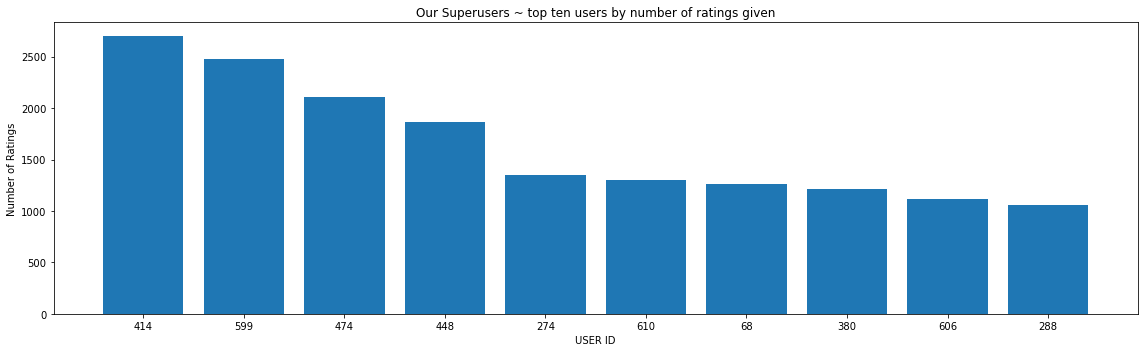

In [271]:
# create variables for easier reuse
user_ratings_count = df_movies_raters_genres['userId'].value_counts()

# Top 10 users with the most ratings
top_users = user_ratings_count[:10]

plt.figure(figsize=(16,5))
plt.bar(x=range(len(top_users)), height=top_users.values, tick_label=top_users.index)  # Changed to plt.bar()
plt.xlabel("USER ID")
plt.ylabel("Number of Ratings")
plt.title("Our Superusers ~ top ten users by number of ratings given")

plt.tight_layout()
plt.show();

In [272]:
query = \
"""
SELECT MAX(r.rating) as highest_rating, r.movieID, m.title, m.genres, r.userID, COUNT(r.userID) AS num_movies_rated
FROM ratings as r
LEFT JOIN movies AS m ON m.movieId = r.movieId
GROUP BY r.userId
ORDER BY num_movies_rated DESC;
"""
df_movie_raters = pd.read_sql_query(sql=text(query), con=engine.connect())

In [273]:
df_movie_raters.head(10)

,highest_rating,movieId,title,genres,userId,num_movies_rated
0,5.0,11,"American President, The (1995)",Comedy|Drama|Romance,414,2698
1,5.0,112,Rumble in the Bronx (Hont faan kui) (1995),Action|Adventure|Comedy|Crime,599,2478
2,5.0,17,Sense and Sensibility (1995),Drama|Romance,474,2108
3,5.0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,448,1864
4,5.0,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,274,1346
5,5.0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,610,1302
6,5.0,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,68,1260
7,5.0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,380,1218
8,5.0,232,Eat Drink Man Woman (Yin shi nan nu) (1994),Comedy|Drama|Romance,606,1115
9,5.0,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,288,1055


In [274]:
df_movie_raters.tail()

,highest_rating,movieId,title,genres,userId,num_movies_rated
605,5.0,2858,American Beauty (1999),Drama|Romance,207,20
606,4.5,1090,Platoon (1986),Drama|War,194,20
607,5.0,58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,189,20
608,5.0,225,Disclosure (1994),Drama|Thriller,147,20
609,5.0,203,"To Wong Foo, Thanks for Everything! Julie Newm...",Comedy,53,20


In [275]:
df_movie_raters.describe()

,highest_rating,movieId,userId,num_movies_rated
count,610.000000,610.000000,610.000000,610.000000
mean,4.957377,2452.804918,305.500000,165.304918
std,0.191750,13999.538480,176.236111,269.480584
min,2.500000,1.000000,1.000000,20.000000
25%,5.000000,32.000000,153.250000,35.000000
50%,5.000000,150.000000,305.500000,70.500000
75%,5.000000,527.000000,457.750000,168.000000
max,5.000000,177765.000000,610.000000,2698.000000


In [276]:
query = \
"""
SELECT r.userID, m.title, m.genres, r.rating, MAX(r.rating) as highest_rated, COUNT(r.userID) AS num_movies_rated
FROM ratings AS r
JOIN movies AS m ON m.movieId = r.movieId
GROUP BY r.userID
ORDER BY num_movies_rated DESC;
"""
df_users_highest_rated_movies = pd.read_sql_query(sql=text(query), con=engine.connect())

In [277]:
df_users_highest_rated_movies.head(10)

,userId,title,genres,rating,highest_rated,num_movies_rated
0,414,"American President, The (1995)",Comedy|Drama|Romance,5.0,5.0,2698
1,599,Rumble in the Bronx (Hont faan kui) (1995),Action|Adventure|Comedy|Crime,5.0,5.0,2478
2,474,Sense and Sensibility (1995),Drama|Romance,5.0,5.0,2108
3,448,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,5.0,1864
4,274,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,5.0,5.0,1346
5,610,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,5.0,1302
6,68,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,5.0,5.0,1260
7,380,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,5.0,1218
8,606,Eat Drink Man Woman (Yin shi nan nu) (1994),Comedy|Drama|Romance,5.0,5.0,1115
9,288,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,5.0,5.0,1055


In [278]:
df_users_highest_rated_movies.tail(10)

,userId,title,genres,rating,highest_rated,num_movies_rated
600,431,True Romance (1993),Crime|Thriller,5.0,5.0,20
601,406,Ever After: A Cinderella Story (1998),Comedy|Drama|Romance,5.0,5.0,20
602,320,"Negotiator, The (1998)",Action|Crime|Drama|Mystery|Thriller,4.0,4.0,20
603,278,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,5.0,5.0,20
604,257,This Is Spinal Tap (1984),Comedy,4.5,4.5,20
605,207,American Beauty (1999),Drama|Romance,5.0,5.0,20
606,194,Platoon (1986),Drama|War,4.5,4.5,20
607,189,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,5.0,5.0,20
608,147,Disclosure (1994),Drama|Thriller,5.0,5.0,20
609,53,"To Wong Foo, Thanks for Everything! Julie Newm...",Comedy,5.0,5.0,20


In [279]:
query = \
"""
SELECT r.userID, COUNT(r.userID) AS num_movies_rated
FROM ratings as r
LEFT JOIN movies AS m ON m.movieId = r.movieId
GROUP BY r.userId
ORDER BY num_movies_rated DESC;
"""
df_raters_ratings_count = pd.read_sql_query(sql=text(query), con=engine.connect())

In [280]:
df_raters_ratings_count.head(10)

,userId,num_movies_rated
0,414,2698
1,599,2478
2,474,2108
3,448,1864
4,274,1346
5,610,1302
6,68,1260
7,380,1218
8,606,1115
9,288,1055


In [281]:
# Biggest Superuser: 414

query = \
"""
SELECT r.userID, m.title, m.genres, r.rating
FROM ratings AS r
JOIN movies AS m ON m.movieId = r.movieId
WHERE r.userId = 414
ORDER BY r.rating DESC;
"""
df_super_user_414 = pd.read_sql_query(sql=text(query), con=engine.connect())

## Creating a naive baseline model

If our model predicted the mean rating for every user it would be off by 1 point on average.  

In [282]:
stats = ratings_df[['rating']].describe()
stats

,rating
count,100836.000000
mean,3.501557
std,1.042529
min,0.500000
25%,3.000000
50%,3.500000
75%,4.000000
max,5.000000


In [283]:
# sanity check
mean_rating = 3.5
rmse_naive = np.sqrt(((ratings_df['rating'] - mean_rating) ** 2).mean())
print(rmse_naive)

1.0425252322754481


## Model Iterations using `surprise`

In [284]:
#Creating a surprise compatible dataframe
query = \
"""
SELECT userID, movieID, rating
FROM ratings;
"""
df_ratings_surprise = pd.read_sql_query(sql=text(query), con=engine.connect())

In [285]:
# read in values as Surprise dataset
reader = Reader()
data = Dataset.load_from_df(df_ratings_surprise, reader)


### Using `GridSearchCV` to find the best parameters

The SVD model using the recommended parameters below would still be off by almost .88 on average. A slight improvement over the baseline.

In [286]:
# Define hyperparameter grid
param_grid = {
    'n_factors':[100,200],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.4, 0.6]
}

# Perform grid search
gs = GridSearchCV(SVD, param_grid=param_grid, n_jobs = -1, measures=['rmse', 'mae'], cv=5)
gs.fit(data)

# Print best RMSE score
print(gs.best_score["rmse"])

# Print optimal parameters
print(gs.best_params['rmse'])



0.8797058362706023
{'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4}


In [287]:
gs.best_estimator

{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x1dd69eb7790>,
 'mae': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x1dd69eb78b0>}

In [288]:
gs.best_score

{'rmse': 0.8797058362706023, 'mae': 0.6797062066531876}

In [289]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name': 'pearson', 'user_based': True})

cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1)

In [290]:
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([0.97152618, 0.97912152, 0.9781549 , 0.97135018, 0.96379315]))
('test_mae', array([0.75045325, 0.75344198, 0.75544188, 0.75040163, 0.74457395]))
('fit_time', (0.652101993560791, 0.6950340270996094, 0.6650846004486084, 0.6713826656341553, 0.6423904895782471))
('test_time', (1.1193113327026367, 1.1073307991027832, 1.1173315048217773, 1.0701394081115723, 1.1127698421478271))
-----------------------
0.9727891873579109


In [291]:
# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name': 'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, data)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [292]:
for i in cv_knn_baseline.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([0.87564839, 0.88042706, 0.87771661, 0.87648656, 0.87479554]))
('test_mae', array([0.66848683, 0.67361902, 0.67217929, 0.66671404, 0.66733531]))
('fit_time', (0.721764326095581, 0.7299253940582275, 0.7352886199951172, 0.7337930202484131, 0.7380189895629883))
('test_time', (1.494704246520996, 1.4586281776428223, 1.4586679935455322, 1.6203227043151855, 1.4675006866455078))
-----------------------
0.877014831787317


In [293]:
 #Split data into "train-validation set" and "test set"
train, test = surprise.model_selection.train_test_split(data,test_size=0.25, random_state=42)

In [294]:
# Train a final model on the "train-validation set" with the best found parameters
final_model = SVD(**gs.best_params['rmse'])
final_model.fit(train)

# test model on the "test set"
predictions = final_model.test(test)

In [295]:
surprise.accuracy.mae(final_model.test(test))

MAE:  0.6839


0.6838521368267947

In [296]:
surprise.accuracy.rmse(final_model.test(test))

RMSE: 0.8856


0.8855915228727995

 ### Modeling off a dataset that filters out "superusers"

#### Visualizing distribution of ratings

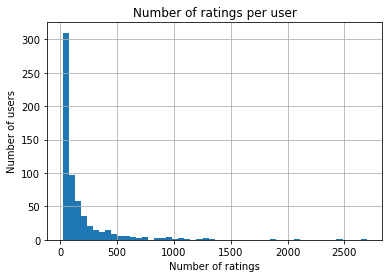

In [297]:
ratings_per_user = ratings_df.groupby('userId').size()
ratings_per_user.hist(bins=50)
plt.title('Number of ratings per user')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show();


#### Determining the impact of filtering on dataset size

In [298]:
for threshold in [50, 70, 100, 200, 500, 1000]:
    print(f"Threshold: {threshold}")
    print(f"Number of users: {sum(ratings_per_user <= threshold)}")
    print(f"Number of ratings: {ratings_per_user[ratings_per_user <= threshold].sum()}")
    print()


Threshold: 50
Number of users: 232
Number of ratings: 7374

Threshold: 70
Number of users: 305
Number of ratings: 11707

Threshold: 100
Number of users: 365
Number of ratings: 16823

Threshold: 200
Number of users: 477
Number of ratings: 32552

Threshold: 500
Number of users: 567
Number of ratings: 60782

Threshold: 1000
Number of users: 598
Number of ratings: 82319



### Model Iteration: Filtering out users who submitted > 500 ratings

In [299]:
# Calculate the number of ratings made by each user
ratings_per_user = ratings_df.groupby('userId').size()

# Define your threshold for a superuser. This is something we might adjust.
# In this example, we're assuming anyone who's rated more than 500 movies is a superuser.
superuser_threshold = 500

# Identify the superusers
superusers = ratings_per_user[ratings_per_user > superuser_threshold].index

# Filter out the superusers
superusers_filtered_out_df = ratings_df[~ratings_df.userId.isin(superusers)]


In [300]:
superusers_filtered_out_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [301]:
new_df = superusers_filtered_out_df.drop(columns='timestamp')

In [302]:
new_df['rating'].describe()

count    60782.000000
mean         3.636035
std          1.055376
min          0.500000
25%          3.000000
50%          4.000000
75%          4.500000
max          5.000000
Name: rating, dtype: float64

In [303]:
# read in values as Surprise dataset
reader = Reader()
data_filtered = Dataset.load_from_df(new_df, reader)

In [304]:
# Define hyperparameter grid
param_grid = {
    'n_factors':[100,200],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.4, 0.6]
}

# Perform grid search
gs = GridSearchCV(SVD, param_grid=param_grid, n_jobs = -1, measures=['rmse', 'mae'], cv=5)
gs.fit(data_filtered)

# Print best RMSE score
print(gs.best_score["rmse"])

# Print optimal parameters
print(gs.best_params['rmse'])


0.9174661391496113
{'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4}


In [305]:
gs.best_estimator

{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x1dd61cf3160>,
 'mae': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x1dd6a314640>}

In [306]:
gs.best_score

{'rmse': 0.9174661391496113, 'mae': 0.7052479260113447}

In [307]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name': 'pearson', 'user_based': True})

cv_knn_basic = cross_validate(knn_basic, data_filtered, n_jobs=-1)

In [308]:
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([1.04578111, 1.03411078, 1.04937496, 1.02915608, 1.04672051]))
('test_mae', array([0.7982793 , 0.79463584, 0.80443312, 0.78739876, 0.80313164]))
('fit_time', (0.453397274017334, 0.45140552520751953, 0.47135257720947266, 0.4454193115234375, 0.43689417839050293))
('test_time', (0.6346328258514404, 0.5867595672607422, 0.5882232189178467, 0.6151518821716309, 0.5872573852539062))
-----------------------
1.041028687212605


In [309]:
# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name': 'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, data_filtered)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [310]:
for i in cv_knn_baseline.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([0.94235769, 0.94574681, 0.94001211, 0.92988349, 0.92629986]))
('test_mae', array([0.71606447, 0.72041968, 0.7147278 , 0.70851519, 0.70288125]))
('fit_time', (0.43291473388671875, 0.42716050148010254, 0.4409196376800537, 0.4262125492095947, 0.4423713684082031))
('test_time', (0.784752368927002, 0.7873706817626953, 0.7963743209838867, 0.7929396629333496, 0.7870492935180664))
-----------------------
0.936859991683689


In [311]:
 #Split data into "train-validation set" and "test set"
train, test = surprise.model_selection.train_test_split(data_filtered,test_size=0.25, random_state=42)

In [312]:
# Train a final model on the "train-validation set" with the best found parameters
final_model_nosupers = SVD(**gs.best_params['rmse'])
final_model_nosupers.fit(train)

# Finally, test your model on the "test set"
predictions = final_model_nosupers.test(test)

In [313]:
surprise.accuracy.mae(final_model_nosupers.test(test))

MAE:  0.7064


0.7064340103193906

In [314]:
surprise.accuracy.rmse(final_model_nosupers.test(test))

RMSE: 0.9213


0.921283446615512

#### Visualizing ratings distribution with superusers (> 500 ratings) filtered out

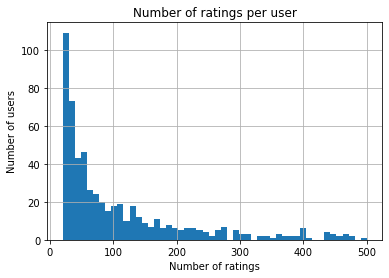

In [315]:
ratings_per_user = new_df.groupby('userId').size()
ratings_per_user.hist(bins=50)
plt.title('Number of ratings per user')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show();

### Model Iteration: Filtering out users who submitted > 1000 ratings

In [316]:
# Calculate the number of ratings made by each user
ratings_per_user = ratings_df.groupby('userId').size()

# Define your threshold for a superuser. This is something we might adjust.
# In this example, we're assuming anyone who's rated more than 500 movies is a superuser.
superuser_threshold = 1000

# Identify the superusers
superusers = ratings_per_user[ratings_per_user > superuser_threshold].index

# Filter out the superusers
superusers_1000_filtered_out_df = ratings_df[~ratings_df.userId.isin(superusers)]


In [317]:
superusers_1000_filtered_out_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [318]:
new_df2 = superusers_1000_filtered_out_df.drop(columns='timestamp')

In [319]:
new_df2['rating'].describe()

count    82319.000000
mean         3.554410
std          1.058603
min          0.500000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

In [320]:
# read in values as Surprise dataset
reader = Reader()
data_filtered2 = Dataset.load_from_df(new_df2, reader)

In [321]:
# Define hyperparameter grid
param_grid = {
    'n_factors':[100,200],
    'n_epochs': [20, 30],
    'lr_all': [0.002, 0.005],
    'reg_all': [0.4, 0.6]
}

# Perform grid search
gs = GridSearchCV(SVD, param_grid=param_grid, n_jobs = -1, measures=['rmse', 'mae'], cv=5)
gs.fit(data_filtered2)

# Print best RMSE score
print(gs.best_score["rmse"])

# Print optimal parameters
print(gs.best_params['rmse'])


0.9059368485913154
{'n_factors': 100, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.4}


In [322]:
gs.best_estimator

{'rmse': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x1dd611079d0>,
 'mae': <surprise.prediction_algorithms.matrix_factorization.SVD at 0x1dd620042e0>}

In [323]:
gs.best_score

{'rmse': 0.9059368485913154, 'mae': 0.6985597246772702}

In [324]:
# cross validating with KNNBasic
knn_basic = KNNBasic(sim_options={'name': 'pearson', 'user_based': True})

cv_knn_basic = cross_validate(knn_basic, data_filtered2, n_jobs=-1)

In [325]:
for i in cv_knn_basic.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_basic['test_rmse']))

('test_rmse', array([1.01873465, 1.02196393, 1.00889085, 1.01929197, 0.99518925]))
('test_mae', array([0.78478709, 0.78409648, 0.7773287 , 0.7819495 , 0.76695292]))
('fit_time', (0.643913984298706, 0.6189801692962646, 0.6469202041625977, 0.6214518547058105, 0.5935075283050537))
('test_time', (0.9193592071533203, 0.8539655208587646, 0.9108190536499023, 0.9257786273956299, 0.8584299087524414))
-----------------------
1.0128141284722658


In [326]:
# cross validating with KNNBaseline
knn_baseline = KNNBaseline(sim_options={'name': 'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, data_filtered2)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [327]:
for i in cv_knn_baseline.items():
    print(i)
print('-----------------------')
print(np.mean(cv_knn_baseline['test_rmse']))

('test_rmse', array([0.92298136, 0.91920187, 0.90758923, 0.91140071, 0.91086024]))
('test_mae', array([0.70681943, 0.69968544, 0.69116529, 0.69410271, 0.69596655]))
('fit_time', (0.6674685478210449, 0.6352565288543701, 0.6276841163635254, 0.6740601062774658, 0.6309421062469482))
('test_time', (1.1973869800567627, 1.191089391708374, 1.1971538066864014, 1.2176432609558105, 1.197359323501587))
-----------------------
0.9144066828156256


In [328]:
 #Split data into "train-validation set" and "test set"
train, test = surprise.model_selection.train_test_split(data_filtered2,test_size=0.25, random_state=42)

In [329]:
# Train a final model on the "train-validation set" with the best found parameters
final_model_no_1000_supers = SVD(**gs.best_params['rmse'])
final_model_no_1000_supers.fit(train)

# Finally, test your model on the "test set"
predictions = final_model_no_1000_supers.test(test)

In [330]:
surprise.accuracy.mae(final_model_no_1000_supers.test(test))

MAE:  0.6940


0.6940383254979265

In [331]:
surprise.accuracy.rmse(final_model_no_1000_supers.test(test))

RMSE: 0.8998


0.8998146150793004

#### Visualizing ratings distribution with superusers (> 1000 ratings) filtered out

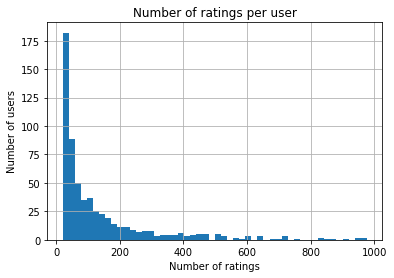

In [332]:
ratings_per_user = new_df2.groupby('userId').size()
ratings_per_user.hist(bins=50)
plt.title('Number of ratings per user')
plt.xlabel('Number of ratings')
plt.ylabel('Number of users')
plt.show();

## Final Model: XGBoost

In [333]:
# Create variable for average rating
global_bias = df_ratings_surprise['rating'].mean()

# Create variables for user bias (how much user's mean rating deviates from the overall mean (3.5))
# and item bias (how much a movie's mean rating differs from the overall mean (3.5))
df_user_bias = df_ratings_surprise.groupby('userId')['rating'].mean() - global_bias
df_item_bias = df_ratings_surprise.groupby('movieId')['rating'].mean() - global_bias

# add biases to DataFrame
df = df_ratings_surprise.join(df_user_bias, on='userId', rsuffix='_user_bias')
final_df = df.join(df_item_bias, on='movieId', rsuffix='_item_bias')


In [334]:
# create X and y variables
X = final_df.drop(['rating'], axis=1)
y = final_df['rating']

# create a DMatrix (the recommended input for xgboost models)
data_dmatrix = xgb.DMatrix(data=X, label=y)

# define the parameters for the xgboost model
params = {"objective":'reg:squarederror', 'random_state':42}

# call the cv function
# cv_results contains train and test RMSE metrics for each boosting round
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=100, early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=42)


In [335]:
# find the best number of boosting rounds
best_num_rounds = cv_results['test-rmse-mean'].idxmin()
best_num_rounds

67

In [336]:
# train the xgboost model with the best number of boosting rounds
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=best_num_rounds)

# save this model for later use
xg_reg.save_model('my_model.json')

### Evaluating the model

In [337]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
63,0.751374,0.001166,0.789902,0.003784
64,0.750882,0.001247,0.789799,0.003778
65,0.750590,0.001357,0.789791,0.003742
66,0.750127,0.001304,0.789801,0.003780
67,0.749650,0.001182,0.789784,0.003781


In [338]:
mae = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5, num_boost_round=100, early_stopping_rounds=10, metrics="mae", as_pandas=True, seed=42)
mae.tail()

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
76,0.565119,0.000846,0.597352,0.001671
77,0.564749,0.000816,0.597349,0.001696
78,0.564480,0.000756,0.597311,0.001679
79,0.564080,0.000748,0.597299,0.001719
80,0.563664,0.000724,0.597267,0.001726


#### Feature Importance
Number of splits across all the trees in our model:
* `'userId'`: 816
* `'movieId'`: 1092
* `'rating_user_bias'`: 829
* `'rating_item_bias'`: 983

In [339]:
print(xg_reg.get_score(importance_type='weight')) # or 'gain' or 'cover'


{'rating_item_bias': 983, 'rating_user_bias': 829, 'movieId': 1092, 'userId': 816}


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

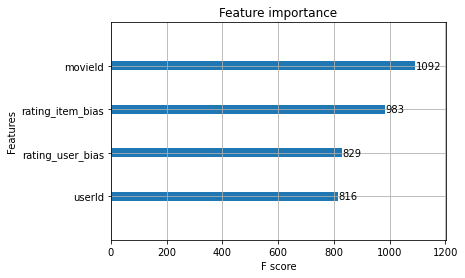

In [340]:
xgb.plot_importance(xg_reg)

## Conclusions and Future Steps

After completing our EDA and modeling with tuning, we recommend a hybrid model of both content filtering and collaborative filtering to accurately predict that a user would highly rate a movie within .79 stars. Our collaborative data includes user and movie id while our content data calculates bias in feature importance. Movie ID, Movie Rating Bias, User Rating Bias, and User ID were our most important features after splitting across trees in our model. As an expansive database, user-friendly interface, and exceptional recommendation accuracy, LIkeWise can use our model to enhance the movie-watching experience for millions of users worldwide. 

For our futures steps, we would like to look into a larger data set as our analysis was performed on roughly 100K ratings. We would also like to address matrix factorization struggles by considering additional techniques such as incorporating content-based features. An example solution would be to us a collaborative filtering approach to generate a shortlist of recommendations. We would then use a more flexible model like a neural network to rank the shortlist.